In [ ]:
!pip install emd

In [ ]:
!pip install numpy==1.21

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import emd
from scipy import ndimage

In [ ]:
path = r'/content/drive/MyDrive/REGISTROS EEG/02_Eduarda_f.set'

matdat1 = loadmat(path)

In [ ]:
matdat1['chanlocs'][0][8][0]

array(['F8'], dtype='<U2')

In [ ]:
data = matdat1['data'][8]

In [ ]:
edges, centres = emd.spectra.define_hist_bins_from_data(data)

In [ ]:
sample_rate = 256

config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 'if'
config['mask_amp_mode'] = 'ratio_imf'
config['imf_opts/sd_thresh'] = 0.5
config['mask_step_factor'] = 5

imf = emd.sift.mask_sift(data, **config)
#emd.plotting.plot_imfs(imf[:sample_rate*5, :])

In [ ]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

In [ ]:
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2


# Define sift parameters for the second level
masks = np.array([25/2**ii for ii in range(12)])/sample_rate
config = emd.sift.get_config('mask_sift')
config['mask_amp_mode'] = 'ratio_imf'
config['max_imfs'] = 5
config['imf_opts/sd_thresh'] = 0.05
config['envelope_opts/interp_method'] = 'pchip'

# Sift the first 5 first level IMFs
imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

In [ ]:
IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')

In [ ]:
carrier_hist = (1, 100, 128,'log')

#and one for the amplitude modulations
am_hist = (1e-2, 100, 128, 'log')

#compute 1d HHT (power over carrier freq)
fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
shht = ndimage.gaussian_filter(hht, 2)

fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
sholo = ndimage.gaussian_filter(holo, 1)

<ipython-input-78-bc59dec98861>:2: UserWarning: The following kwargs were not used by contour: 'shade'
  cp = ax.contourf(fcarrier, fam, sholo.T**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo.T)**0.25, np.max(sholo.T)**0.25, 40))


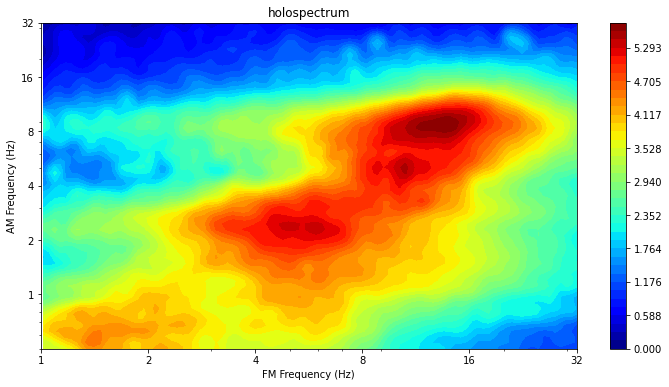

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(12,6))
cp = ax.contourf(fcarrier, fam, sholo.T**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo.T)**0.25, np.max(sholo.T)**0.25, 40))
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.5,32)
plt.xlim(1,32)
plt.yticks(2**np.arange(6),2**np.arange(6))
plt.xticks(2**np.arange(6),2**np.arange(6))
plt.colorbar(cp)
#cb.set_label(r'$V^{2}$', rotation=0)
ax.set_title('holospectrum')
ax.set_xlabel('FM Frequency (Hz)')
ax.set_ylabel('AM Frequency (Hz)')
plt.show()

In [ ]:
seconds = 420
sample_rate = 256
t = np.linspace(0, seconds, seconds*sample_rate)

([<matplotlib.axis.YTick at 0x7fe95f697e80>,
 [Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 8, '8'),
  Text(0, 16, '16'),
  Text(0, 32, '32')])

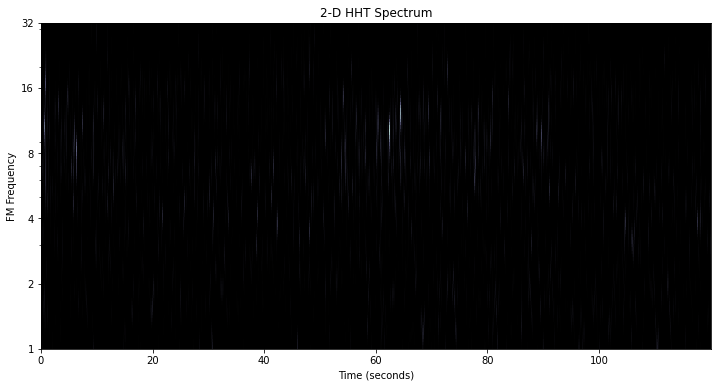

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(12,6))
plt.pcolormesh((t[:sample_rate*120]), fcarrier, (shht[:, :sample_rate*120]), cmap='bone')
plt.yscale('log')
plt.title('2-D HHT Spectrum')
plt.xlabel('Time (seconds)')
plt.ylabel('FM Frequency')
plt.ylim(2,32)
plt.yticks(2**np.arange(6), 2**np.arange(6))